# Code snippets

In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

In [2]:
from dill.source import getsource, getsourcelines


## Importance sampling
* I modified the evaluator from hw2 to also return $\sigma$, which gets accumulated from the `log_prob` of evaluating observes

In [3]:
for line_number, function_line in enumerate(getsourcelines(evaluate)[0]):
    print(line_number, function_line,end='')

0 def evaluate(e,sigma=0,local_env={},defn_d={},do_log=False,logger_string=''):
1     # TODO: get local_env to evaluate values to tensors, not regular floats
2     # remember to return evaluate (recursive)
3     # everytime we call evaluate, we have to use local_env, otherwise it gets overwritten with the default {}
4     # if do_log: logger.info('logger_string {}'.format(logger_string))
5     if do_log: logger.info('ls {}'.format(logger_string))
6     if do_log: logger.info('e {}, local_env {}, sigma {}'.format(e, local_env, sigma))
7 
8     # get first expression out of list or list of one
9     if not isinstance(e,list) or len(e) == 1:
10         if isinstance(e,list):
11             e = e[0]
12         if isinstance(e,bool):
13             if do_log: logger.info('match case number: e {}, sigma {}'.format(e, sigma))
14             return torch.tensor(e), sigma
15         if isinstance(e, number):
16             if do_log: logger.info('match case number: e {}, sigma {}'.format(e, sig

I also wrote my own score function. It handles boolean cases by converting them to 

In [4]:
from evaluation_based_sampling import score
for line_number, function_line in enumerate(getsourcelines(score)[0]):
    print(line_number, function_line,end='')

0 def score(distribution,c):
1     """Score pytorch distributions with .log_prob, but in a robust way for the type of c
2     """
3     if isinstance(c,bool) or c.type() in ['torch.BoolTensor', 'torch.LongTensor']:
4         log_w = distribution.log_prob(c.double())
5     else:
6         log_w = distribution.log_prob(c)
7     return log_w


I added a few more distributions and boolean operation primitives, for the problems in this assignment

In [5]:
from evaluation_based_sampling import score
for line_number, function_line in enumerate(getsourcelines(score)[0]):
    print(line_number, function_line,end='')

0 def score(distribution,c):
1     """Score pytorch distributions with .log_prob, but in a robust way for the type of c
2     """
3     if isinstance(c,bool) or c.type() in ['torch.BoolTensor', 'torch.LongTensor']:
4         log_w = distribution.log_prob(c.double())
5     else:
6         log_w = distribution.log_prob(c)
7     return log_w


In [6]:
from primitives import distributions_d
for key in distributions_d.keys() :
    print(key,':')
    for line_number, function_line in enumerate(getsourcelines(distributions_d[key])[0]):
        print(line_number, function_line,end='')
    print()

normal :
0 def normal(mean_std):
1     return two_arg_op_primitive(torch.distributions.Normal,mean_std)

beta :
0 def beta(alpha_beta):
1     return two_arg_op_primitive(torch.distributions.Beta,alpha_beta)

exponential :
0 def exponential(lam):
1     return one_arg_op_primitive(torch.distributions.Exponential,lam)

uniform :
0 def uniform(low_hi):
1     return two_arg_op_primitive(torch.distributions.Uniform,low_hi)

discrete :
0 def discrete(prob_vector):
1     return one_arg_op_primitive(torch.distributions.Categorical,prob_vector)

flip :
0 def flip(prob):
1     return one_arg_op_primitive(torch.distributions.bernoulli.Bernoulli,prob)

dirichlet :
0 def dirichlet(concentration):
1     return one_arg_op_primitive(torch.distributions.dirichlet.Dirichlet,concentration)

gamma :
0 def gamma(concentration_rate):
1     return two_arg_op_primitive(torch.distributions.gamma.Gamma,concentration_rate)



In [7]:
from primitives import primitives_d
for key in ['and','or','>','<','>=','<=','='] :
    print(key,':')
    for line_number, function_line in enumerate(getsourcelines(primitives_d[key])[0]):
        print(line_number, function_line,end='')
    print()

and :
0 def and_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.logical_and,arg1_arg2)  

or :
0 def or_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.logical_or,arg1_arg2)  

> :
0 def gt_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.gt,consequent_alternative)

< :
0 def lt_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.lt,consequent_alternative)

>= :
0 def ge_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.ge,consequent_alternative)

<= :
0 def le_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.le,consequent_alternative)

= :
0 def eq_primitive(consequent_alternative):
1     return two_arg_op_primitive(torch.eq,consequent_alternative)



## Problem 1

In [19]:
from load_helper import ast_helper, graph_helper


### Importance sampling

In [9]:
import parse
import importance_sampling
import importlib
importlib.reload(parse)

<module 'parse' from '/Users/gw/repos/prob_prog/hw/hw3/parse.py'>

In [10]:
fname = '1.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['mu', ['sample', ['normal', 1, ['sqrt', 5]]]],
  ['let',
   ['sigma', ['sqrt', 2]],
   ['let',
    ['lik', ['normal', 'mu', 'sigma']],
    ['let',
     ['dontcare0', ['observe', 'lik', 8]],
     ['let', ['dontcare1', ['observe', 'lik', 9]], 'mu']]]]]]

In [11]:
num_samples=100
samples, sigmas = parse.take_samples(num_samples,ast)
samples = np.array([sample.item() for sample in samples])

Text(0.5, 0, 'mu')

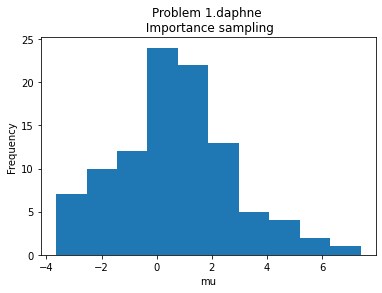

In [12]:
pd.Series(samples).plot.hist()
plt.title('Problem {} \n Importance sampling'.format(fname))
plt.xlabel('mu')


In [13]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)
posterior_mean

7.258425321748714

In [14]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas) 
posterior_variance = expectation_samples_2 - posterior_mean**2

In [15]:
"Importance sampling: posterior mean {:1.3f} | variance {:1.3e}".format(posterior_mean,posterior_variance)

'Importance sampling: posterior mean 7.258 | variance 1.959e-01'

### MH within Gibbs

In [18]:
fname = '1.daphne' 
import load_helper
graph = load_helper.graph_helper(fname)
graph

[{},
 {'V': ['observe3', 'observe4', 'sample2'],
  'A': {'sample2': ['observe3', 'observe4']},
  'P': {'sample2': ['sample*', ['normal', 1, ['sqrt', 5]]],
   'observe3': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 8],
   'observe4': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 9]},
  'Y': {'observe3': 8, 'observe4': 9}},
 'sample2']

### Problem 2

### Importance sampling

In [ ]:
fname = '2.daphne' 
ast = ast_helper(fname)

In [ ]:
samples, sigmas = parse.take_samples(num_samples=1000,ast=ast)
samples = np.array([sample.tolist() for sample in samples])

In [ ]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas,reshape_probs=(-1,1),axis=0)
posterior_mean

In [ ]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas,reshape_probs=(-1,1),axis=0) 
posterior_variance = expectation_samples_2 - posterior_mean**2
posterior_variance

In [ ]:
expectation_samplex_sampley, probs = importance_sampling.weighted_average(samples[:,0]*samples[:,1],sigmas) 
covariance = expectation_samplex_sampley - posterior_mean[0]*posterior_mean[1]
covariance

In [ ]:
for result in [
    "{} Importance sampling: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} Importance sampling: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} Importance sampling: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

Numpy contains it's own method for computing this, and we can check it agrees with our results (where things are spelt out a bit more for learning purposes).

In [ ]:
np.cov(samples.T,aweights=probs,ddof=0)

## 3.daphne

### Importance sampling

In [ ]:
fname = '3.daphne' 
ast = ast_helper(fname)
ast

In [ ]:
samples, sigmas = parse.take_samples(num_samples=100,ast=ast)
samples = np.array([sample.item() for sample in samples])

In [ ]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)


In [ ]:
"""The posterior probability that the first and second datapoint are in the same cluster,\
i.e. the posterior probability that z[1] == z[2]: {:0.3f}\
""".format(posterior_mean)

## 4.daphne

### Importance sampling

In [ ]:
fname = '4.daphne' 
ast = ast_helper(fname)
ast

In [ ]:
samples,sigmas = parse.take_samples(num_samples=10,ast=ast)
samples = np.array([sample.item() for sample in samples])

In [ ]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)
posterior_mean

In [ ]:
"""The posterior probability that it is raining, i.e. of “is-raining.”: {:0.3f}""".format(posterior_mean)